**Installing Plotly for Visualization Help**

In [ ]:
!pip install --upgrade plotly

**Importing Libraries**

In [2]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")        
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


In [3]:
import plotly as py
import plotly.graph_objs as go
import plotly.express as px

In [4]:
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif

**Data Exploration**

We will start by looking at the basic information of the dataset, such as it's head, it's type, how many the null columns are and so on.

In [5]:
aug_train = pd.read_csv('aug_train.csv')
aug_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [ ]:
aug_train.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


In [ ]:
aug_train.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [ ]:
def count_percent(data):
  df_cols = pd.DataFrame({'Count Missing': data.isnull().sum(),
                        'Percent Missing': data.isnull().sum()*100/data.shape[0]})
  return df_cols

count_percent(aug_train)

,Count Missing,Percent Missing
enrollee_id,0,0.000000
city,0,0.000000
city_development_index,0,0.000000
gender,4508,23.530640
relevent_experience,0,0.000000
enrolled_university,386,2.014824
education_level,460,2.401086
major_discipline,2813,14.683161
experience,65,0.339284
company_size,5938,30.994885


We've discovered that 4 columns have a lot of data missing, the rest have a bit of data missing or none at all. We can drop the the values that have around 2% missing, and we will try to impute the rest on the next part, based on the feature type.

In [ ]:
aug_train.duplicated().sum()

0

Next, we will try to see the data distribution of each features. To ease this process, we will define a function to plot simple bar graph and pie chart.

In [ ]:
# Function to Plot Bar Graph
def plot_bar_graph(column, order=None):
    x = aug_train[column].value_counts().index
    y = aug_train[column].value_counts().values
    sns.barplot(x, y, order=order)
     
# Funtion to Plot Pie Chart
def plot_pie_chart(column, title=''):
    values = aug_train[column].value_counts().values
    labels = aug_train[column].value_counts().index
    plt.figure(figsize=(6,6))
    plt.title(title)
    plt.pie(x=values, labels=labels, autopct='%1.2f%%')

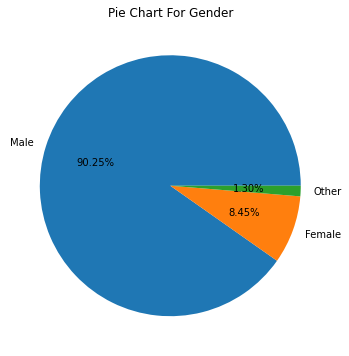

In [ ]:
plot_pie_chart('gender', title='Pie Chart For Gender')
plt.show()

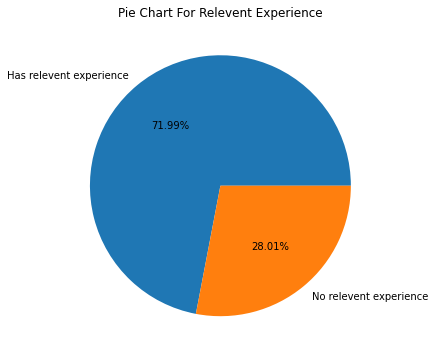

In [ ]:
plot_pie_chart('relevent_experience', title='Pie Chart For Relevent Experience')
plt.show()

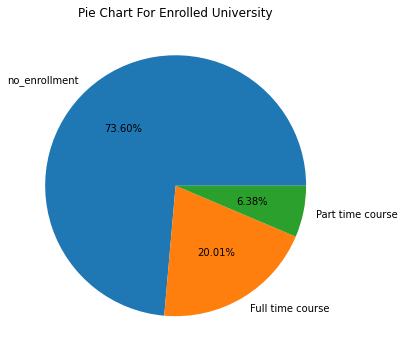

In [ ]:
plot_pie_chart('enrolled_university', title='Pie Chart For Enrolled University')
plt.show()

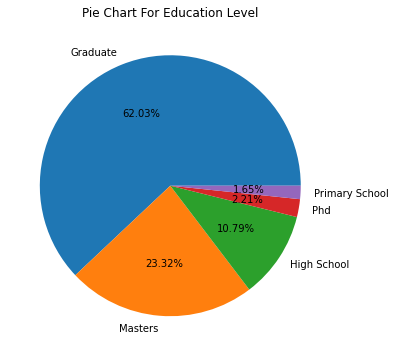

In [ ]:
plot_pie_chart('education_level', title='Pie Chart For Education Level')
plt.show()

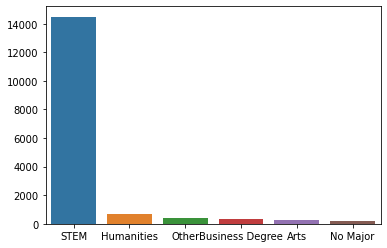

In [ ]:
plot_bar_graph('major_discipline')
plt.show()

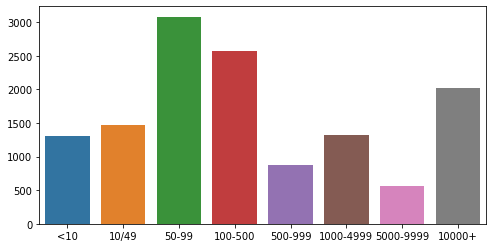

In [ ]:
plt.figure(figsize=(8, 4))
order = ['<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
plot_bar_graph('company_size', order=order)
plt.show()

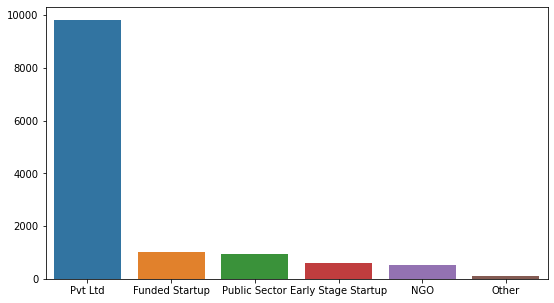

In [ ]:
plt.figure(figsize=(9, 5))
plot_bar_graph('company_type')
plt.show()

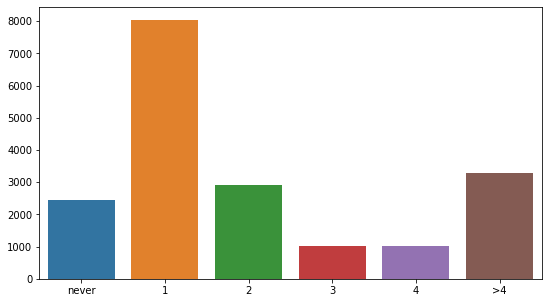

In [ ]:
plt.figure(figsize=(9, 5))
order = ['never', '1', '2', '3', '4', '>4']
plot_bar_graph('last_new_job', order=order)
plt.show()

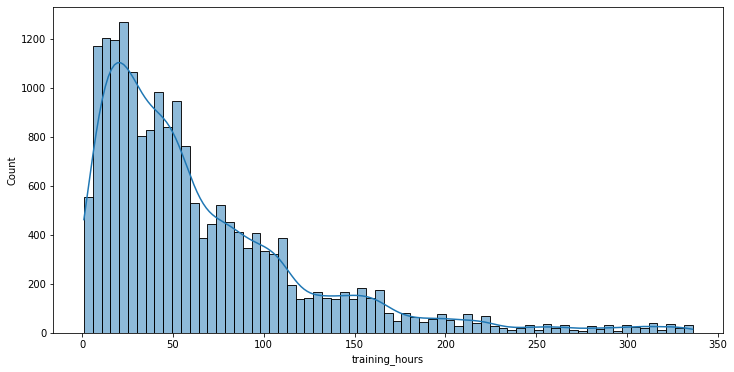

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(aug_train['training_hours'], kde=True)

We see that the data is mostly imbalanced. This will tried to be fixed later in preprocessing/methodology part. Next, we will try to plot each features with the target column. This is to see and decide if the feature can help in predicting. Also, since the data is imbalanced we will try to normalize some of the visualization to make it easier in interpreting it.

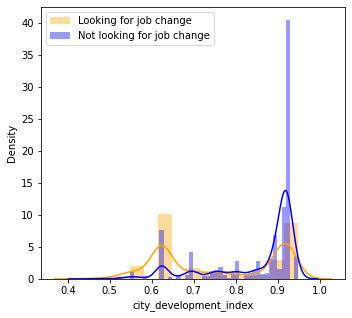

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,2)
sns.distplot(aug_train[aug_train['target'] == 1.0]['city_development_index'][0:] , label = "Looking for job change", color = 'Orange')
sns.distplot(aug_train[aug_train['target'] == 0.0]['city_development_index'][0:] , label = "Not looking for job change" , color = 'blue' )
plt.legend()
plt.show();

We see that a lot of people in lower city development index (especially 0.6) is looking for jobs, and in higher city development index (especially in 0.9) is not looking for jobs. This indicates that city development index affects the target column.

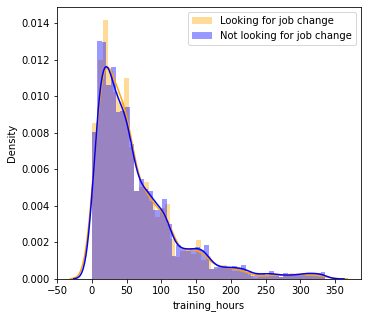

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,2)
sns.distplot(aug_train[aug_train['target'] == 1.0]['training_hours'][0:] , label = "Looking for job change", color = 'Orange')
sns.distplot(aug_train[aug_train['target'] == 0.0]['training_hours'][0:] , label = "Not looking for job change" , color = 'blue' )
plt.legend()
plt.show();

Next we want to see training hours. We first assumed that people who wants to look for jobs will train more. But looking at the graph it seems not true and it's pretty much the same. So we decide that training hours do not affect the target column.

Let's try checking it with other type of plot, like boxplot.

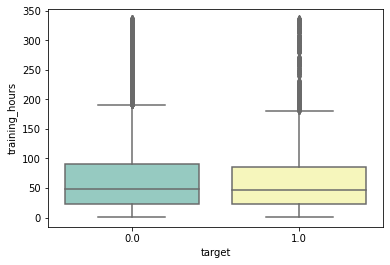

In [7]:
 sns.boxplot(y="training_hours", x="target",data=aug_train, palette="Set3")

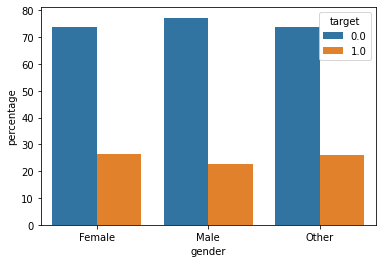

In [ ]:
gender = (aug_train.groupby(['gender'])['target']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('gender'))

sns.barplot(x="gender", y="percentage", hue="target", data=gender)

The graph above is not labbled, but 1.0 is for people looking for jobs and 0 is for people not looking for jobs. Next, we see that in gender, the distribution pretty much is the same accross the board, meaning it's not affecting the target column.

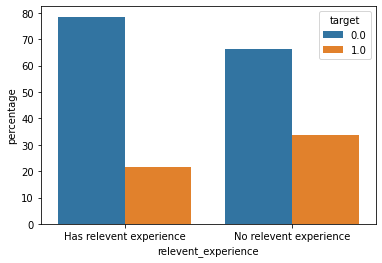

In [ ]:
expr = (aug_train.groupby(['relevent_experience'])['target']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('relevent_experience'))

sns.barplot(x="relevent_experience", y="percentage", hue="target", data=expr)

Next we see that people with no relevent experience tends to look for jobs more.

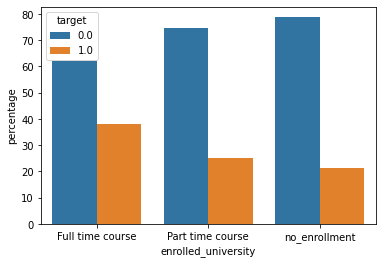

In [ ]:
enrolled = (aug_train.groupby(['enrolled_university'])['target']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('enrolled_university'))

sns.barplot(x="enrolled_university", y="percentage", hue="target", data=enrolled)

We see here that people with further enrollment in university have a tendency to look for jobs more.

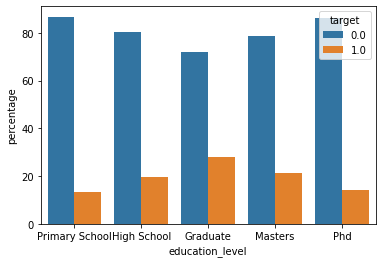

In [ ]:
edu = (aug_train.groupby(['education_level'])['target']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('education_level'))
order = ['Primary School','High School', 'Graduate', 'Masters', 'Phd']

sns.barplot(x="education_level", y="percentage", hue="target", data=edu, order=order)

Next we see that from primary school to graduate, it seems the will to look for jobs is getting bigger, but from graduate to phd, people tend to not look for jobs anymore. We decide that this column may still affect target column.

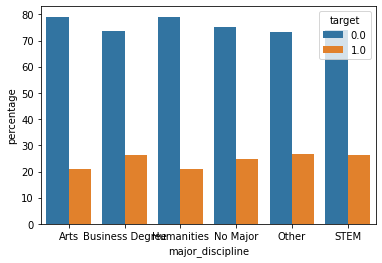

In [ ]:
disc = (aug_train.groupby(['major_discipline'])['target']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('major_discipline'))

sns.barplot(x="major_discipline", y="percentage", hue="target", data=disc)

Next, we see that education background have a varying distribution although not too much. We can't see quite a pattern here, but it seems people from business degree, STEM, and others, want to look for jobs more than people from arts or humanities degree.

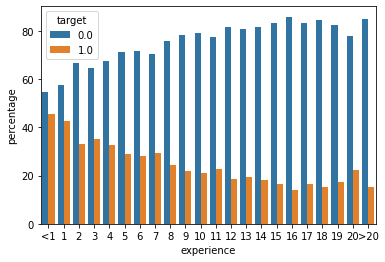

In [ ]:
texp = (aug_train.groupby(['experience'])['target']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values("experience"))
order = ['<1','1', '2', '3', '4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','>20']

sns.barplot(x="experience", y="percentage", hue="target", data= texp, order=order)

Now from total expeerience column, we see that there's a tendency where people with less total experience look for jobs more.

In [ ]:
#company_size
company_size = aug_train["company_size"].value_counts()


cs = aug_train.groupby(['target', 'company_size']).agg({'target': 'count'}).rename(columns = {'target': 'count'}).reset_index()

fig = px.sunburst(cs,path = ['target', 'company_size'],  values = 'count', color = 'target',
                 color_discrete_map = {'Looking for a job change': 'red', 'Not looking for job change': 'green'},
                 width = 600, height = 600)

fig.update_layout(annotations = [dict(text = 'Affect of company size on the desire to change job', 
                                      x = 0.5, y = 1.1, font_size = 14, showarrow = False, 
                                      font_family = 'Calibri Black',
                                      font_color = 'black')])

fig.update_traces(textinfo = 'label + percent parent')
                  
fig.show(renderer="colab")

From here, we see that the composition of each range for those looking for jobs or not is pretty much the same (ex: 50-99 is both on 23%). We could interpret this column as not affecting job change.

In [ ]:
cs = aug_train.groupby(['target', 'company_type']).agg({'target': 'count'}).rename(columns = {'target': 'count'}).reset_index()

fig = px.sunburst(cs,path = ['target', 'company_type'],  values = 'count', color = 'target',
                 color_discrete_map = {'Looking for a job change': 'red', 'Not looking for job change': 'green'},
                 width = 600, height = 600)

fig.update_layout(annotations = [dict(text = 'Affect of company type on the desire to change job', 
                                      x = 0.5, y = 1.1, font_size = 14, showarrow = False, 
                                      font_family = 'Calibri Black',
                                      font_color = 'black')])

fig.update_traces(textinfo = 'label + percent parent')
                  
fig.show(renderer="colab")

Next we will also see the effect of company type. Here we also see that it's pretty much the same as the previous case. The composition only differ around 3% and seems to not affect the decision to look for jobs or not.

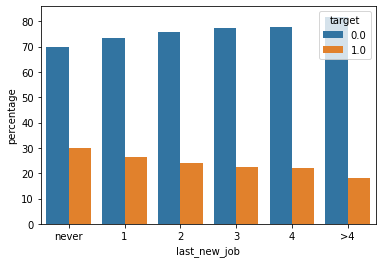

In [ ]:
last = (aug_train.groupby(['last_new_job'])['target']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values("last_new_job"))
order = ['never','1', '2', '3', '4','>4']

sns.barplot(x="last_new_job", y="percentage", hue="target", data= last, order=order)

Next, we see that theres a pattern wehere people who stayed longer in their last jobs do not want a job change. This column seems to affect the target column.

`**Column Exploration Result:**

1. We see that the data is mostly imbalanced on all columns.
2. We can assume that enrolee_id and city column is not affecting target column, since it's mostly for identification purpose. We can drop these columns.
3. Through column exploration, we discovered some features/column like gender, company type, training hours, and company size is not affecting the target column significantly. We will drop these columns.
4. We also see a lot of missing values for gender, company type and company size column. But we will drop these features. As for education level, last new job, experience, and enrollment, we will drop the null values since it's not too much. Lastly for major discipline, we wil try to impute using mode.

**Statistics and Multicollinearity Check**

We want to see if any of the columns have multicollinearity and correlates each other. If it is discovered that some columns have multicollinearity we will drop them, since it can cause bias in our model and misinterpretation.

First, there will be separation of categorical data and numerical data, because to test the correlation between categorical and numeric variables, different methods are used.


In [ ]:
aug_train_cat = aug_train.select_dtypes(include = 'object').copy()
aug_train_num = aug_train.select_dtypes(include = 'number').copy()
aug_train_cat.columns

Index(['city', 'gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'experience', 'company_size',
       'company_type', 'last_new_job'],
      dtype='object')

In [ ]:
aug_train_num.columns

Index(['enrollee_id', 'city_development_index', 'training_hours', 'target'], dtype='object')

In [ ]:
aug_train_val = aug_train_num['target']

In [ ]:
aug_train_num.drop(columns=['target'], axis = 1, inplace=True)

Selanjutnya, kita melakukan chi square test.

In [ ]:
chi2_check = {}

for column in aug_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(aug_train_val, aug_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))
# convert dari dictionary ke DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,p-value
0,city,0.000000e+00
1,relevent_experience,0.000000e+00
2,enrolled_university,0.000000e+00
3,education_level,0.000000e+00
4,experience,0.000000e+00
5,last_new_job,0.000000e+00
6,company_size,1.078000e-07
7,company_type,1.480300e-06
8,gender,1.087715e-02
9,major_discipline,3.205736e-02


In [ ]:
F_statistic, p_values = f_classif(aug_train_num, aug_train_val)
# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': aug_train_num.columns.values,
					'F-Score': F_statistic, 'p values': p_values.round(decimals=3)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,city_development_index,2531.716218,0.000
1,enrollee_id,47.004194,0.000
2,training_hours,8.922761,0.003


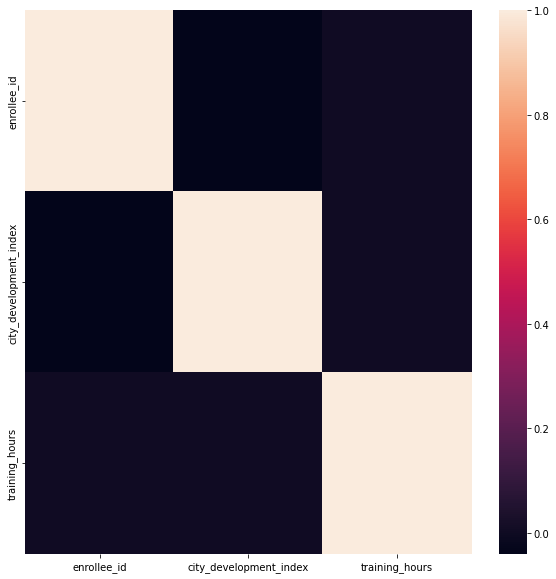

In [ ]:
corrmat = aug_train_num.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)
calc_vif(aug_train_num).sort_values('VIF')

,variables,VIF
2,training_hours,2.135706
0,enrollee_id,3.759770
1,city_development_index,4.729460


Through the tests carried out, it was found that the columns does not have a large correlation, so we can keep them.